## Second Trial

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split


%store -r df1

In [31]:
df1.describe()

,distance_seattle,property_age,rooms_per_floor,sqft_lot,sqft_living,price,renovation_1,renovation_unknown,waterfront_1,waterfront_unknown
count,15742.000000,15742.000000,15742.000000,15742.000000,15742.000000,15742.000000,15742.000000,15742.000000,15742.000000,15742.000000
mean,10.363642,46.145090,3.985293,7254.739169,1840.128827,450911.570576,0.027315,0.179456,0.001461,0.111485
std,5.518193,29.510392,1.427181,3752.395860,672.382422,171196.157571,0.163006,0.383746,0.038197,0.314742
min,0.330000,-1.000000,0.750000,520.000000,370.000000,78000.000000,0.000000,0.000000,0.000000,0.000000
25%,5.610000,21.000000,3.000000,4750.000000,1340.000000,315000.000000,0.000000,0.000000,0.000000,0.000000
50%,9.805000,46.000000,3.750000,7168.500000,1750.000000,428000.000000,0.000000,0.000000,0.000000,0.000000
75%,14.380000,66.000000,4.750000,9219.750000,2256.000000,569000.000000,0.000000,0.000000,0.000000,0.000000
max,22.250000,115.000000,11.500000,21370.000000,5820.000000,856600.000000,1.000000,1.000000,1.000000,1.000000


### Defining the Problem
We'll replace 'sqft_lot' with 'sqft_living' and remove 'waterfront_1' for this trial.

In [32]:
x_variables = ['sqft_living', 'distance_seattle', 'property_age']
outcome = 'price'
X = df1[x_variables] 

### Checking for Multicollinearity

In [33]:
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
          index=X.columns)

sqft_living         5.089413
distance_seattle    4.008493
property_age        2.135195
dtype: float64

VIF scores dropped a few decimal points.

### Fitting our Model

In [34]:
predictors = '+'.join(x_variables)
formula = outcome + '~' + predictors + '-1'
model = ols(formula=formula, data=df1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                          5.976e+04
Date:                Thu, 08 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:51:06   Log-Likelihood:                     -2.0853e+05
No. Observations:               15742   AIC:                                  4.171e+05
Df Residuals:                   15739   BIC:                                  4.171e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
sqft_living        239.6262      1.258    190.525      0.000     237.161     242.091
distance_seattle -8169.6727    186.247    -43.865      0.000   -8534.739   -7804.607
property_age      1730.2172     29.138     59.381      0.000    1673.104    1787.330
==============================================================================
Omnibus:                      133.948   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.717
Skew:                          -0.167   Prob(JB):                     5.65e-35
Kurtosis:                       3.360   Cond. No.                         334.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* *R-squared* and *Adj. R-squared* take on the same value which by itself means about 91.9% of observations can be explained by our model. This is a good number.
* p-values are all zero which means our features are statistically significant.

### Homoscedasticity

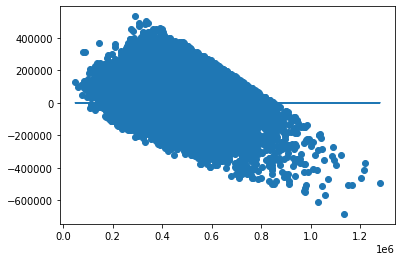

In [45]:
plt.scatter(model.predict(df1[x_variables]), model.resid)
plt.plot(model.predict(df1[x_variables]), [0 for i in range(len(df1))])

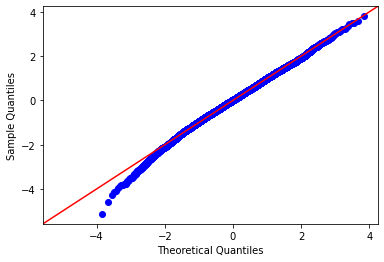

In [46]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Train Test

In [47]:
y = df1[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

12593 3149 12593 3149


In [49]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_hat_train = lin_reg.predict(X_train)
y_hat_test = lin_reg.predict(X_test)

### Residuals and MSE

In [50]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [51]:
from sklearn.metrics import mean_squared_error, make_scorer

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 14155994095.318829
Test Mean Squarred Error: 13745444854.444008


### CrossValidating our Model

In [52]:
from sklearn.model_selection import cross_val_score

In [53]:
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(lin_reg, X, y, cv=5, scoring=mse)

In [54]:
cv_5_results.mean()

14121993908.14033

* Now this model looks a lot better than the first one. 
* On the next notebook (n4) I will add 'waterfront_1' to the features considered for this model. 
* On notebook n5 I will repeat the experiment to add 'renovation_1' and see if it improves our model.

### Final Thoughts and Conclusion

* After performing experiments mentioned above on notebooks n4 and n5 our model did not improve enough so I am concluding the best model is the one contained in the present notebook.
* Our Best Model indicates that we could effectively predict the price of a house in around 92% of observations    with the following features:
    * Size: footage of the home (living space).
    * Location: distance from the center or economic hub.
    * Property Age: how many years ago a house was built.